In [1]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from ipywidgets import interactive, fixed
from sklearn.preprocessing import MinMaxScaler


# Crear un objeto MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01,1))


# Creamos la función que calcula la varianza del ruido a partir del snr dB
def var_snr(x,snrdB):      # x vector de datos (señal), snrdB es SNR en dB
    Px = np.mean(x**2)     # estimador potencia media de la señal
    return Px/(10**(snrdB/10))

**Creación de la señal y la señal con ruido**

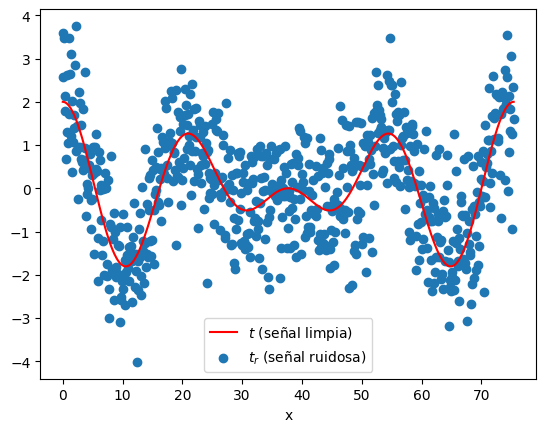

In [2]:
N = 700                              # cantidad de puntos
X = np.linspace(0,24*np.pi, N)       # vector de puntos que va de 0 a 24pi
t = np.cos(X/3) + np.cos(X/4)        # señal limpia


# Creación de la señal ruidosa
snrdB = 1      
var_r = var_snr(t,snrdB)                                # ruido según SNR dB
t_r =  t + np.sqrt(var_snr(t,snrdB))*np.random.randn(N) # señal ruidosa


# graficamos la señal limpia y la señal ruidosa
plt.plot(X,t, label = '$t$ (señal limpia)', c = 'r')
plt.scatter(X,t_r, label = '$t_r$ (señal ruidosa)')
plt.xlabel('x')
plt.legend()

# hacemos que sean vectores columnas
X = X.reshape(-1,1)  #filas = realizaciones-muestras
t = t.reshape(-1,1)

**Dividimos los datos en conjunto de entrenamiento y conjunto de test**

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t_r, test_size=200/700, random_state=42)

# esto es para que los puntos de test se organicen de izquierda a derecha y sean más sencillos de graficar
indices_ordenados = sorted(range(len(X_test)), key=lambda k: X_test[k])
X_test = np.array([X_test[i] for i in indices_ordenados])
t_test = np.array([t_test[i] for i in indices_ordenados])

In [4]:
# Creamos el mapeo que en nuestro caso es un polinomio de orden Q

Q = 10 #grado del polinomio
phiQ = PolynomialFeatures(degree=Q) # son Q+1 componentes contando el bias
Phi_train = scaler.fit_transform(phiQ.fit_transform(X_train)) # representar datos desde polinomio escalados con MinMaxScaler

# **Máxima Verosimilitud**

Para el caso de ruido blanco Gaussiano, tenemos que:

$\eta_n \sim p(\eta_n) = \mathscr{G}(\eta_n|0,\sigma_\eta^2)$

con:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\eta_n = t_n - \phi(\mathbf{x}_n)\mathbf{w}^\top$

Por lo tanto:

$p(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2)$

Podemos encontrar los pesos y la varianza maximizando el log-verosimilitud:

$$\mathbf{w}_{ML} = \arg\max_{\mathbf{w},\sigma_\eta^2} \log\left(\prod_{n=1}^N\mathscr{G}(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2)\right)$$

Asumiendo datos i.i.d.:

$$\mathbf{w}_{ML},\sigma_{ML}^2 = \arg\max_{\mathbf{w},\sigma_\eta^2} -\frac{N}{2}\log(2\pi)-\frac{N}{2}\log(\sigma_\eta^2)-\frac{1}{2\sigma^2}\|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2$$

Derivando respecto a las variables de interés, e igualando a 0:

$$\sigma^2_{ML} = \frac{1}{N}\sum_\limits{n=1}^N\left(t_n-\phi(\mathbf{x}_n)\mathbf{w}^\top\right)^2$$

$$\mathbf{w}_{ML} = \left(\pmb{\Phi}^\top \pmb{\Phi}\right)^{-1}\pmb{\Phi}^\top \mathbf{t}$$


La fdp predictiva, para un nuevo dato $\mathbf{x}_*$, se puede estimar como:

$$p(t_*|\mathbf{x}_*,\mathbf{t},\pmb{\Phi},\mathbf{w}_{ML},\sigma^2_{ML})=\mathscr{G}(t_*|\phi(\mathbf{x}_*)\mathbf{w}_{ML}^\top,\sigma_{ML}^2)$$

Así, definimos $W_{ML}$ y $\sigma_{ML}^2$

In [5]:
# Haciendo las cuentas "manualmente"

W_ML =  np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train # definimos el vector de pesos
sigma_ML = np.mean((t_train - Phi_train @ W_ML)**2)                    # definimos la varianza a partir del vector de pesos
t_estimado = scaler.fit_transform(phiQ.fit_transform(X_test)) @ W_ML                         # t estimado a partir de los pesos obtenidos de ls datos de entrenamiento

In [6]:
# Haciendo las cuentas con Ridge

#from sklearn.linear_model import Ridge
#reg_mc = Ridge()
#reg_mc.fit(Phi_train,t_train) # encontrando la solución W_mc
#t_estimado = reg_mc.predict(phiQ.fit_transform(X_test))

In [7]:
# Función para graficar las dos funciones y el punto seleccionado
def plot_functions(selected_index, X, t, X_test, t_estimado):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # la primera grafica muestra la solución encontrada con el respectivo intervalo de confianza
    ax1.plot(X_test, t_estimado, label = '$t_*$ (estimado)')
    ax1.plot(X, t, label = '$t$ (real)')
    ax1.plot(X_test[selected_index], t_estimado[selected_index], 'ro', label='$(x_*, t_*)$')  # Punto seleccionado en la primera función
    ax1.fill_between(X_test.ravel(), t_estimado.ravel() - np.sqrt(sigma_ML)*np.ones(len(t_estimado)),
                t_estimado.ravel() + np.sqrt(sigma_ML)*np.ones(len(t_estimado)), alpha=0.2, label = 'Intervalo de confianza')
    ax1.set_ylim([min(t_estimado.min(), t_estimado.min())-2,max(t_estimado.max(), t_estimado.max())+2])
    ax1.legend()
    
    # el segundo gráfico muestra la dist. normal correspondiente al punto seleccionado en la primera gráfica
    ax2.hist(np.random.normal(t_estimado[selected_index],sigma_ML,500), bins = 15, orientation='horizontal')
    ax2.set_ylim([min(t_estimado.min(), t_estimado.min())-2,max(t_estimado.max(), t_estimado.max())+2])
    ax2.set_title('$\mathscr{G}(t_*|\phi(\mathbf{x}_*)\mathbf{w}_{ML},\sigma_{ML}^2)$')
    ax2.legend()

    plt.show()

# Creamos un widget interactivo para seleccionar el índice
interactive_plot = interactive(plot_functions, selected_index=(0, len(X_test)-1), X=fixed(X), t=fixed(t), X_test = fixed(X_test), t_estimado=fixed(t_estimado))
interactive_plot

interactive(children=(IntSlider(value=99, description='selected_index', max=199), Output()), _dom_classes=('wi…

# **Simulación por máximo a-posteriori**

$p(\mathbf{t},\mathbf{w})=p(\mathbf{w},\mathbf{t})$

$p(\mathbf{t}|\mathbf{w})p(\mathbf{w})=p(\mathbf{w}|\mathbf{t})p(\mathbf{t})$

El posterior $p(\mathbf{w}|\mathbf{t})$ se puede encontrar como:

$$p(\mathbf{w}|\mathbf{t})=\frac{p(\mathbf{t}|\mathbf{w})p(\mathbf{w})}{p(\mathbf{t})}$$

con evidencia:


$p(\mathbf{t})=\int p(\mathbf{t}|\mathbf{w})p(\mathbf{w}) d\mathbf{w}$

Para el caso de ruido y pesos modelados mediante fdp Gaussinas:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\eta_n \sim p(\eta_n)= \mathscr{G}(\eta_n|0,\sigma_\eta^2)$

$\eta_n = t_n - \phi(\mathbf{x}_n)\mathbf{w}^\top$

Por lo tanto:

$p(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}\left(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2\right)$

Además:

$p(\mathbf{w})= \mathscr{G}(\mathbf{w}|0,\sigma_w^2\mathbf{I}_Q)$

El modelo por máximo a-posteriori, simplifica la relación de Bayes mediante la proporcionalidad:

$p(\mathbf{w}|\mathbf{t}) \propto p(\mathbf{t}|\mathbf{w})p(\mathbf{w})$

Por consiguiente, +

$$\mathbf{w}_{MAP} = \arg\max_{\mathbf{w}} \log\left(\prod_{n=1}^N\mathscr{G}\left(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2\right)\prod_{q=1}^Q \mathscr{G}({w}_q|0,\sigma_w^2)\right)$$

Asumiendo datos i.i.d, 

$$\mathbf{w}_{MAP} = \arg\max_{\mathbf{w}} -\frac{1}{2\sigma_\eta^2}\|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2 - \frac{1}{2\sigma_w^2}\|\mathbf{w}\|^2_2$$

Teniendo en cuenta que los factores de escala no modifican el punto mínimo/máximo en la optmización, podemos factorizar el problema equivalente MAP como:


$$\mathbf{w}_{MAP} = \arg\min_{\mathbf{w}} \|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2 + \frac{\sigma^2_\eta}{\sigma_w^2}\|\mathbf{w}\|^2_2$$

Bajo estas suposiciones, el problema de optimización de MAP asumiendo ruido y prior Gaussianos, es equivalente a la optimización de mínimos cuadrados regularizados con $\lambda=\frac{\sigma^2_\eta}{\sigma_w^2}.$ Es decir,

$$\mathbf{w}_{MAP} = \left(\pmb{\Phi}^\top \pmb{\Phi}+ \frac{\sigma^2_\eta}{\sigma_w^2} \pmb{I}\right)^{-1}\pmb{\Phi}^\top \mathbf{t}$$


In [8]:
# establecemos una varianza para nuestro prior y calculamos el W_MAP y el sigma_MAP "manualmente"

var_w = 25
l = var_r / var_w
W_MAP =  np.linalg.inv(Phi_train.T @ Phi_train + np.diag(l * np.ones(Q+1)) ) @ Phi_train.T @ t_train 
sigma_MAP = np.mean((t_train - Phi_train @ W_MAP)**2)
t_estimado_MAP = scaler.fit_transform(phiQ.fit_transform(X_test)) @ W_MAP

In [9]:
# Haciendo las cuentas con Ridge

#var_w = 1
#l = var_r / var_w
#from sklearn.linear_model import Ridge, LinearRegression
#reg_mc = Ridge(l)
#reg_mc.fit(Phi_train,t_train) # encontrando la solución W_MAP
#t_estimado = reg_mc.predict(phiQ.fit_transform(X_test))

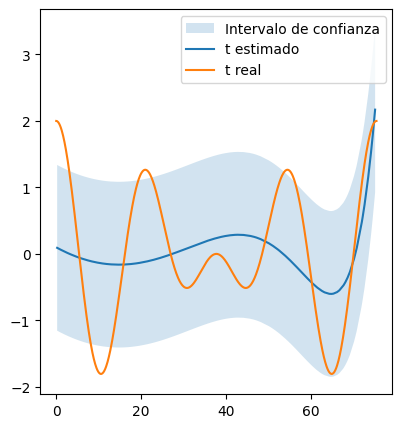

In [10]:
# Crear nuevas variables para almacenar los resultados ordenados

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.fill_between(X_test.ravel(), t_estimado_MAP.ravel() - np.sqrt(sigma_MAP)*np.ones(len(t_estimado_MAP)),
                t_estimado_MAP.ravel() + np.sqrt(sigma_MAP)*np.ones(len(t_estimado_MAP)), alpha=0.2, label = 'Intervalo de confianza')

plt.plot(X_test, t_estimado_MAP, label = 't estimado')
plt.plot(X, t, label = 't real')
plt.legend()